In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

# XSEDE dataset

In [3]:
sxsede = pd.read_csv('data/sessions.csv', index_col=0)
pxsede = pd.read_csv('data/pilots.csv', index_col=0)
uxsede = pd.read_csv('data/units.csv', index_col=0)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sxsede.loc[(sxsede['nunit'] >= 4   ) & (sxsede['nunit'] < 8   ), 'nunit_requested'] = 4
sxsede.loc[(sxsede['nunit'] >= 8   ) & (sxsede['nunit'] < 16  ), 'nunit_requested'] = 8
sxsede.loc[(sxsede['nunit'] >= 16  ) & (sxsede['nunit'] < 32  ), 'nunit_requested'] = 16
sxsede.loc[(sxsede['nunit'] >= 32  ) & (sxsede['nunit'] < 64  ), 'nunit_requested'] = 32
sxsede.loc[(sxsede['nunit'] >= 64  ) & (sxsede['nunit'] < 128 ), 'nunit_requested'] = 64
sxsede.loc[(sxsede['nunit'] >= 128 ) & (sxsede['nunit'] < 256 ), 'nunit_requested'] = 128
sxsede.loc[(sxsede['nunit'] >= 256 ) & (sxsede['nunit'] < 512 ), 'nunit_requested'] = 256
sxsede.loc[(sxsede['nunit'] >= 512 ) & (sxsede['nunit'] < 1024), 'nunit_requested'] = 512
sxsede.loc[(sxsede['nunit'] >= 1024) & (sxsede['nunit'] < 2048), 'nunit_requested'] = 1024
sxsede.loc[(sxsede['nunit'] >= 2048) & (sxsede['nunit'] < 4096), 'nunit_requested'] = 2048
sxsede.loc[(sxsede['nunit'] >= 4096) & (sxsede['nunit'] < 8192), 'nunit_requested'] = 4096

sxsede['nunit_rescheduled'] = sxsede['nunit'] - sxsede['nunit_requested']

In [5]:
stampede = ['rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017261.0002', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017261.0003', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0001', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0007']
comet = ['rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017261.0000', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0004', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017267.0013', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017269.0001']
supermic_matteo = ['rp.session.one.mturilli.017239.0009', 'rp.session.one.mturilli.017238.0011', 'rp.session.one.mturilli.017239.0010', 'rp.session.one.mturilli.017238.0012', 'rp.session.one.mturilli.017239.0011', 'rp.session.one.mturilli.017238.0013', 'rp.session.one.mturilli.017239.0014', 'rp.session.one.mturilli.017238.0014', 'rp.session.one.mturilli.017239.0017', 'rp.session.one.mturilli.017238.0017', 'rp.session.one.mturilli.017239.0018', 'rp.session.one.mturilli.017238.0018', 'rp.session.one.mturilli.017239.0019', 'rp.session.one.mturilli.017239.0003', 'rp.session.one.mturilli.017239.0020', 'rp.session.one.mturilli.017239.0005', 'rp.session.one.mturilli.017239.0021', 'rp.session.one.mturilli.017239.0006', 'rp.session.one.mturilli.017239.0022', 'rp.session.one.mturilli.017239.0007']
supermic_ming = ['rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017261.0004', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0000', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0002', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0003', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0004', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0005', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0006', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0007', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0008', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0009', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0010', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017263.0001', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0001', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0002', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0003', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0004', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0005', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0006', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0007', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0008', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0009', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0010', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0011', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0012', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0013', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0014', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0015', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0016', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0017', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0018', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0019', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0020', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0022', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0023', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0024', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0025', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0026', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0027', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0028', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0029', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0030', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0031', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0032', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0033', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0034', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0035', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0036', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0037', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0038', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0039', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0040', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0041', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0042', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0043', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0044', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0045', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0005', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0008', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0009', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0010', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0011', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0012', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0013']
supermic = supermic_matteo+supermic_ming

ustampede = uxsede.loc[uxsede.sid.isin(stampede)]
ucomet = uxsede.loc[uxsede.sid.isin(comet)]
usupermic_matteo = uxsede.loc[uxsede.sid.isin(supermic_matteo)]
usupermic_ming = uxsede.loc[uxsede.sid.isin(supermic_ming)]
usupermic = uxsede.loc[uxsede.sid.isin(supermic)]

In [6]:
print 'Number of units run on Stampede: %s' % ustampede.shape[0]
print 'Number of units run on Comet: %s' % ucomet.shape[0]
print 'Number of units run on SuperMIC (Matteo\'s experiments): %s' % usupermic_matteo.shape[0]
print 'Number of units run on SuperMIC (Ming\'s experiments): %s' % usupermic_ming.shape[0]
print 'Number of units run on SuperMIC: %s' % usupermic.shape[0]

Number of units run on Stampede: 3088
Number of units run on Comet: 3088
Number of units run on SuperMIC (Matteo's experiments): 20480
Number of units run on SuperMIC (Ming's experiments): 63504
Number of units run on SuperMIC: 83984


# OSG dataset

In [7]:
# Load wrangled data saved in .csv files.
sosg = pd.read_csv('../../OSG/analysis/data/sessions.csv', index_col=0)
posg = pd.read_csv('../../OSG/analysis/data/pilots.csv', index_col=0)
uosg = pd.read_csv('../../OSG/analysis/data/units.csv', index_col=0)

# Drop experiments with at least 8 tasks but less than 8 posg.
sosg = sosg[sosg.experiment != 'exp1']
posg = posg[posg.experiment != 'exp1']
uosg = uosg[uosg.experiment != 'exp1']
sosg = sosg[sosg.experiment != 'exp2']
posg = posg[posg.experiment != 'exp2']
uosg = uosg[uosg.experiment != 'exp2']
sosg = sosg[sosg.experiment != 'exp3']
posg = posg[posg.experiment != 'exp3']
uosg = uosg[uosg.experiment != 'exp3']

# Check for spurious data due to bugs and drop them
sosg = sosg.drop(['rp.session.radical.mturilli.017128.0000', 
                  'rp.session.radical.mturilli.017139.0003',
#                   'rp.session.radical.mturilli.017131.0005',  # outlier Tq
                  'rp.session.radical.mturilli.017230.0003',  # outlier TTC (Tr)
                  'rp.session.radical.mturilli.017212.0011',  # inconsistency in concurrency
                  'rp.session.radical.mturilli.017223.0000',  # inconsistency in concurrency
                  'rp.session.radical.mturilli.017228.0001'])  # inconsistency in concurrency
#                   'rp.session.radical.mturilli.017229.0003']) # inconsistency in concurrency 

posg = posg[posg.sid != 'rp.session.radical.mturilli.017139.0003']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017128.0000']
# posg = posg[posg.sid != 'rp.session.radical.mturilli.017131.0005']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017230.0003']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017212.0011']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017223.0000']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017228.0001']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017229.0003']

uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017139.0003']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017128.0000']
# uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017131.0005']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017230.0003']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017212.0011']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017223.0000']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017228.0001']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017229.0003']

# Derive number of uosg requested and number of uosg 
# rescheduled due to pilot halted/migrated by condor
sosg.loc[(sosg['nunit'] >= 8   ) & (sosg['nunit'] < 16  ), 'nunit_requested'] = 8
sosg.loc[(sosg['nunit'] >= 16  ) & (sosg['nunit'] < 32  ), 'nunit_requested'] = 16
sosg.loc[(sosg['nunit'] >= 32  ) & (sosg['nunit'] < 64  ), 'nunit_requested'] = 32
sosg.loc[(sosg['nunit'] >= 64  ) & (sosg['nunit'] < 128 ), 'nunit_requested'] = 64
sosg.loc[(sosg['nunit'] >= 128 ) & (sosg['nunit'] < 256 ), 'nunit_requested'] = 128
sosg.loc[(sosg['nunit'] >= 256 ) & (sosg['nunit'] < 512 ), 'nunit_requested'] = 256
sosg.loc[(sosg['nunit'] >= 512 ) & (sosg['nunit'] < 1024), 'nunit_requested'] = 512
sosg.loc[(sosg['nunit'] >= 1024) & (sosg['nunit'] < 2048), 'nunit_requested'] = 1024
sosg.loc[(sosg['nunit'] >= 2048) & (sosg['nunit'] < 4096), 'nunit_requested'] = 2048

sosg['nunit_rescheduled'] = sosg['nunit'] - sosg['nunit_requested']

# Drop runs with nunit_requested < npilot
runs = sosg[sosg.nunit_requested < sosg.npilot]['sid'].tolist()
sosg = sosg[sosg.nunit_requested >= sosg.npilot]
for run in runs:
    posg = posg[posg.sid != run]
    uosg = uosg[uosg.sid != run]

In [8]:
print 'Number of successful runs: %s' % sosg.shape[0]
print 'Number of pilots: %s' % posg.shape[0]
print 'Number of units: %s' % uosg.shape[0]

Number of successful runs: 287
Number of pilots: 39800
Number of units: 153741


# Experiment 1

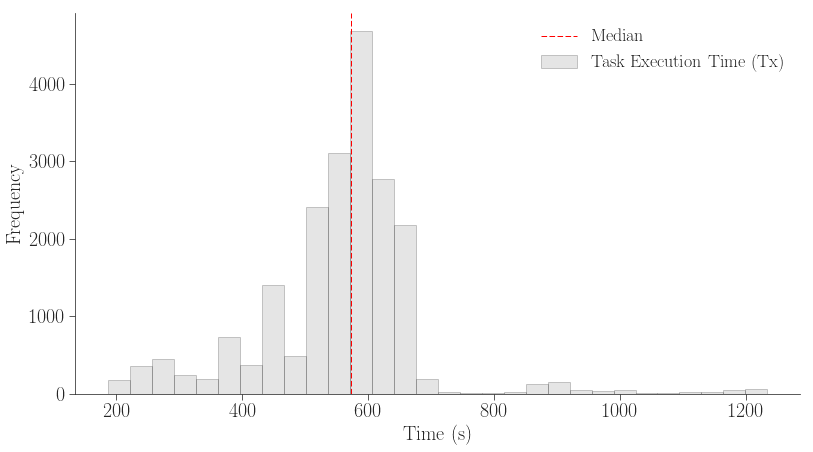

In [9]:
fig, ax = fig_setup()
title='SuperMIC XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
# display(sps.normaltest(usupermic_matteo['U_AGENT_EXECUTING'].dropna().tolist()))
# usupermic_matteo[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
usupermic_matteo[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=30, 
                alpha = 0.20)
#                 normed=True)

plt.axvline(usupermic_matteo['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim(0,1400)
plt.xlabel('Time (s)')

ax.legend(labels=['Median', 'Task Execution Time (Tx)'])

plt.savefig('figures/supermic_matteo_tx_frequency.pdf', dpi=600, bbox_inches='tight')

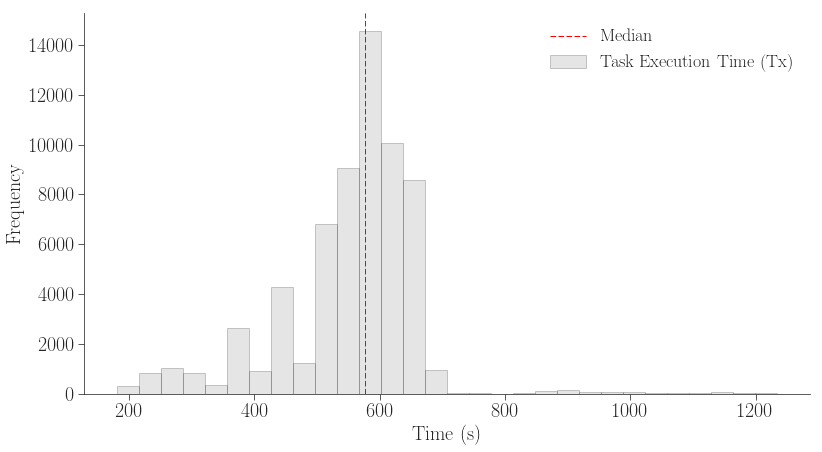

In [10]:
fig, ax = fig_setup()
title='SuperMIC XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
#display(sps.normaltest(usupermic_ming['U_AGENT_EXECUTING'].dropna().tolist()))
#usupermic_ming[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
usupermic_ming[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=30, 
                alpha = 0.20)
#                normed=True)

plt.axvline(usupermic_ming['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim(0,1400)
plt.xlabel('Time (s)')

ax.legend(labels=['Median', 'Task Execution Time (Tx)'])

plt.savefig('figures/supermic_ming_tx_frequency.pdf', dpi=600, bbox_inches='tight')

83984


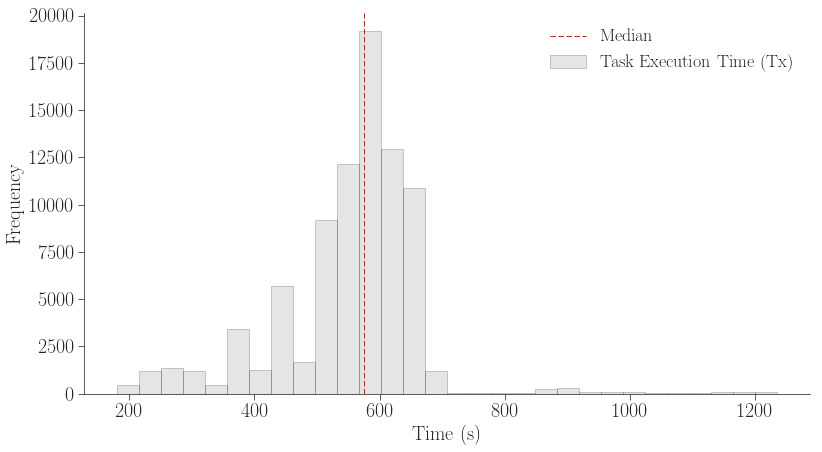

In [11]:
fig, ax = fig_setup()
title='SuperMIC XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
#display(sps.normaltest(usupermic['U_AGENT_EXECUTING'].dropna().tolist()))
#usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram
print usupermic.shape[0]
usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=30, 
                alpha = 0.20) #,
                # normed=True)

plt.axvline(usupermic['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim(0,1400)
plt.xlabel('Time (s)')

ax.legend(labels=['Median', 'Task Execution Time (Tx)'])

# plt.savefig('figures/supermic_tx_frequency.pdf', dpi=600, bbox_inches='tight')

NormaltestResult(statistic=174.83328147962214, pvalue=1.0850138956516921e-38)

3088


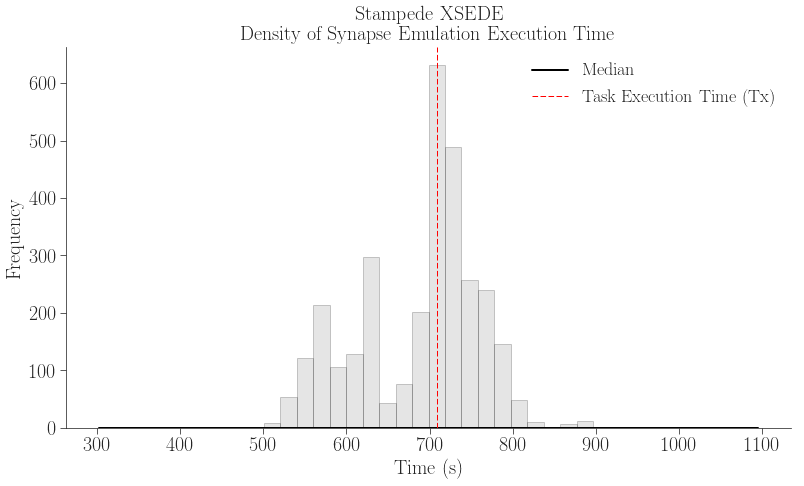

In [12]:
fig, ax = fig_setup()
title='Stampede XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
display(sps.normaltest(ustampede['U_AGENT_EXECUTING'].dropna().tolist()))
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=20,
                alpha = 0.20)#,
#                 normed=True)

plt.axvline(ustampede['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)
# plt.axvline(ustampede['U_AGENT_EXECUTING'].dropna().mode(), color='b', linestyle='dashed', linewidth=1)
# plt.axvline(ustampede['U_AGENT_EXECUTING'].dropna().median(), color='g', linestyle='dashed', linewidth=1)

print len(ustampede['U_AGENT_EXECUTING'])

#ax.set_xlim(0,1400)
plt.xlabel('Time (s)')

ax.legend(labels=['Median', 'Task Execution Time (Tx)'])

plt.savefig('figures/stampede_tx_frequency.pdf', dpi=600, bbox_inches='tight')

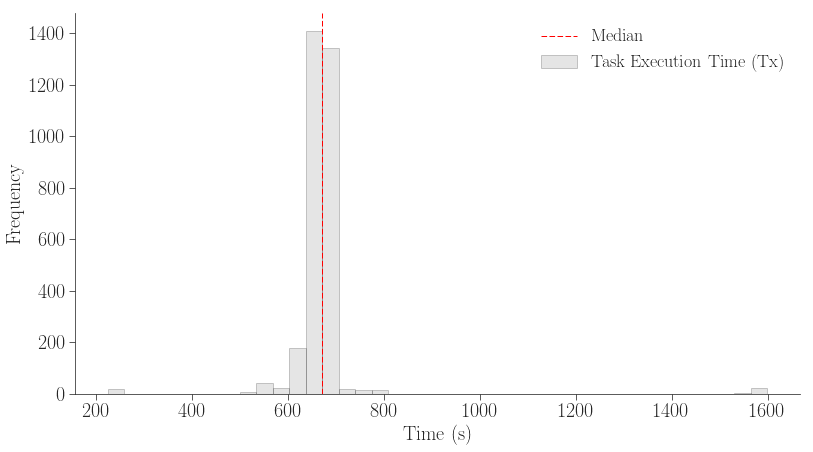

In [13]:
fig, ax = fig_setup()
title='Stampede XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
# display(sps.normaltest(ucomet['U_AGENT_EXECUTING'].dropna().tolist()))
# ucomet[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
ucomet[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=40, 
                alpha = 0.20)
#                 normed=True)

plt.axvline(ucomet['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim(400,900)
plt.xlabel('Time (s)')

ax.legend(labels=['Median', 'Task Execution Time (Tx)'])

plt.savefig('figures/stampede_tx_frequency.pdf', dpi=600, bbox_inches='tight')

0    199.1968
dtype: float64


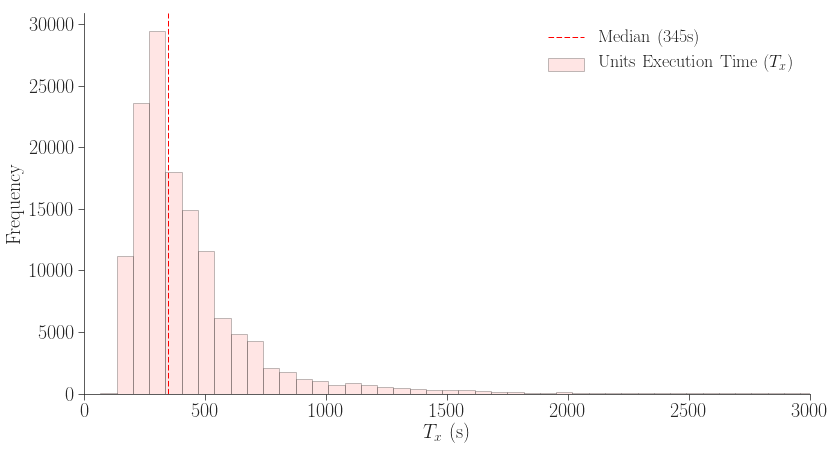

In [14]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)\nNote: Tail truncated at 2000s.'

uosg[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(ax=ax, 
                                                                      color=tableau20[7], 
                                                                      bins=100,
                                                                      alpha = 0.25)#,
#                                                                        normed=True)
# units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, 
#                                                                           color='black', 
#                                                                           title=title)
plt.axvline(uosg['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

print uosg['U_AGENT_EXECUTING'].dropna().mode()

ax.set_xlim(0, 3000)

ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Median (%is)' % uosg['U_AGENT_EXECUTING'].dropna().median(), 'Units Execution Time ($T_x$)'])

plt.savefig('figures/osg_dstrb_tx_all.pdf', dpi=600, bbox_inches='tight')

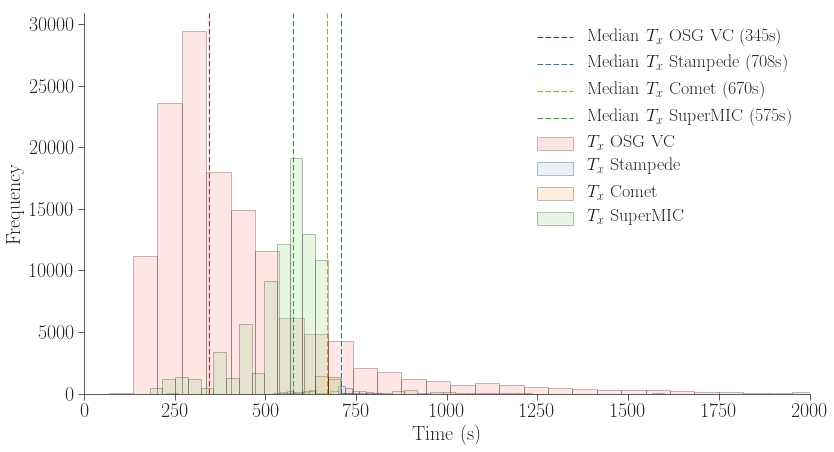

In [15]:
fig, ax = fig_setup()
title='Stampede, Comet and SuperMIC XSEDE\nFrequency of Synapse Emulation Execution Time ($T_x$)'

# KDE execution time
# ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color=tableau20[0], title=title)
# ucomet[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color=tableau20[2], title=title)
# usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color=tableau20[4], title=title)

# Normed Histogram
uosg[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
    ax=ax, 
    color=tableau20[7], 
    bins=100,
    alpha = 0.25)#,
#   normed=True)

ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
    ax=ax, 
    color=tableau20[1],
    edgecolor="k",
    bins=20, 
    alpha = 0.25)
#   normed=True)

ucomet[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
    ax=ax, 
    color=tableau20[3],
    edgecolor="k",
    bins=40, 
    alpha = 0.25)
#   normed=True)

usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
    ax=ax, 
    color=tableau20[5],
    edgecolor="k",
    bins=30, 
    alpha = 0.25)
#   normed=True)

plt.axvline(uosg['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(ustampede['U_AGENT_EXECUTING'].dropna().median(), color=tableau20[0], linestyle='dashed', linewidth=1)
plt.axvline(ucomet['U_AGENT_EXECUTING'].dropna().median(), color=tableau20[2], linestyle='dashed', linewidth=1)
plt.axvline(usupermic['U_AGENT_EXECUTING'].dropna().median(), color=tableau20[4], linestyle='dashed', linewidth=1)

ax.set_xlim(0, 2000)
plt.xlabel('Time (s)')

ax.legend(labels=['Median $T_x$ OSG VC (%is)' % uosg['U_AGENT_EXECUTING'].dropna().median(), 
                  'Median $T_x$ Stampede (%is)' % ustampede['U_AGENT_EXECUTING'].dropna().median(), 
                  'Median $T_x$ Comet (%is)' % ucomet['U_AGENT_EXECUTING'].dropna().median(), 
                  'Median $T_x$ SuperMIC (%is)' % usupermic['U_AGENT_EXECUTING'].dropna().median(),
                  '$T_x$ OSG VC','$T_x$ Stampede', '$T_x$ Comet', '$T_x$ SuperMIC', ])

plt.savefig('figures/xsede_tx_frequency.pdf', dpi=600, bbox_inches='tight')

OSG sample size: 135837
Stampede sample size: 3088
Comet sample size: 3088
SuperMIC sample size: 83529


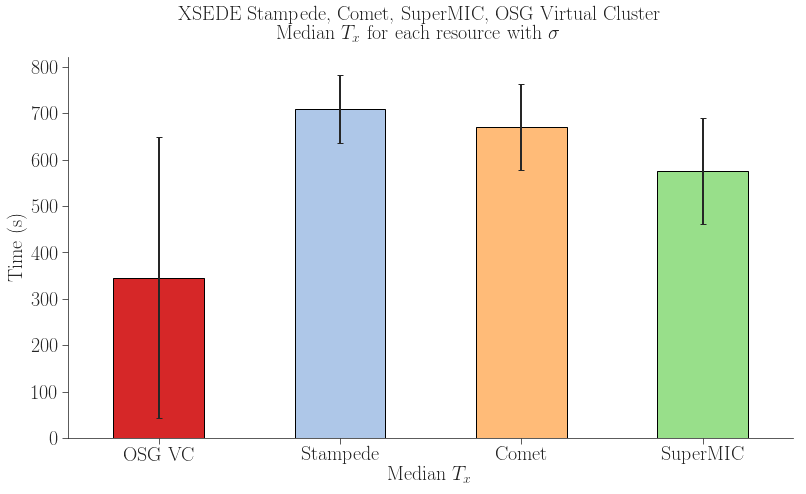

In [16]:
fig, ax = fig_setup()
    
title_head = 'XSEDE Stampede, Comet, SuperMIC, OSG Virtual Cluster'
title_desc = 'Median $T_x$ for each resource with $\sigma$'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

index   = ['OSG VC','Stampede','Comet','SuperMIC']

medians = [uosg['U_AGENT_EXECUTING'].dropna().median(),
         ustampede['U_AGENT_EXECUTING'].dropna().median(),
         ucomet['U_AGENT_EXECUTING'].dropna().median(),
         usupermic['U_AGENT_EXECUTING'].dropna().median()]

stds    = [uosg['U_AGENT_EXECUTING'].dropna().std(),
         ustampede['U_AGENT_EXECUTING'].dropna().std(),
         ucomet['U_AGENT_EXECUTING'].dropna().std(),
         usupermic['U_AGENT_EXECUTING'].dropna().std()]

txs     = pd.DataFrame({'medians': pd.Series(medians, index),
                        'stds'   : pd.Series(stds , index)})

colors = [tableau20[6],tableau20[1],tableau20[3],tableau20[5]]

# Print sample sizes
print 'OSG sample size: %i' % len(uosg['U_AGENT_EXECUTING'].dropna())
print 'Stampede sample size: %i' % len(ustampede['U_AGENT_EXECUTING'].dropna())
print 'Comet sample size: %i' % len(ucomet['U_AGENT_EXECUTING'].dropna())
print 'SuperMIC sample size: %i' % len(usupermic['U_AGENT_EXECUTING'].dropna())


txs.plot(y='medians', yerr='stds',
         color=colors,
         ax=ax,
         kind='bar',
         legend=False,
         rot=0)

ax.set_ylabel('Time (s)')
ax.set_xlabel('Median $T_x$')

plt.savefig('figures/xsede_tx_frequency.pdf', dpi=600, bbox_inches='tight')

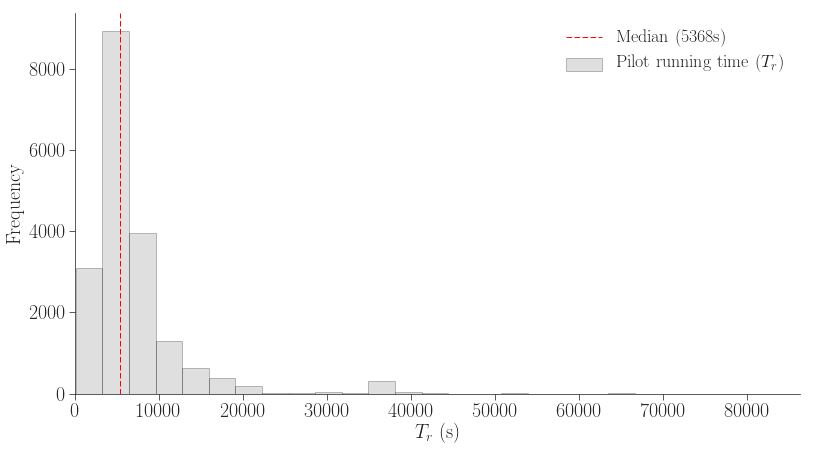

In [17]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)\nNote: Tail truncated at 2000s.'

posg[['P_LRMS_RUNNING']].dropna().reset_index(drop=True).plot.hist(ax=ax, 
                                                                      color='gray',#tableau20[7], 
                                                                      bins=80,
                                                                      alpha = 0.25)#,
#                                                                        normed=True)
# units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, 
#                                                                           color='black', 
#                                                                           title=title)
plt.axvline(posg['P_LRMS_RUNNING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlim(0, 86400)

ax.set_xlabel('$T_r$ (s)')
ax.legend(labels=['Median (%is)' % posg['P_LRMS_RUNNING'].dropna().median(), 'Pilot running time ($T_r$)'])

#plt.savefig('figures/osg_dstrb_tx_all.pdf', dpi=600, bbox_inches='tight')

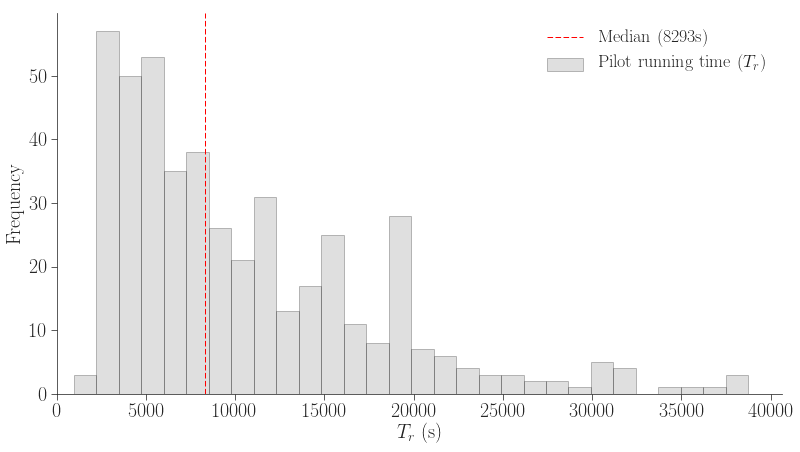

In [82]:
fig, ax = fig_setup()
title= None#'XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)\n.'

# Select pilots with: 
# - units 
# - FAILED final state
# - rescheduled units
# - without duplicated failed time value
# - with failed valued < 10% TTC (heuristic)
#
# 1. termination issues makes the FAILED state unreliable: it 
#    is used also for pilots that were killed by RP. 
# 2. Pilot killed by RP are killed in bulk. Therefore, elimitate
#    pilots with duplicated failed state.
# 3. Pilots available until the end of the session will have 
#    a failed value near the TTC of the session. Eliminate all
#    the pilots with failed value within 1% (heuristic).

pfailed = posg[(posg.nunit > 0) & 
               (posg.FAILED > 0) & 
               (posg.sid.isin(sosg[sosg.nunit_rescheduled > 0].sid.tolist()))
              ].drop_duplicates(subset='FAILED')

for sid in pfailed.sid.tolist():
    pfailed.loc[pfailed.sid == sid, 'TTC'] = sosg[sosg.sid == sid].TTC.values

pfailed = pfailed[pfailed.FAILED < pfailed.TTC-(pfailed.TTC/100.0*10)]


pfailed[['P_LRMS_RUNNING']].dropna().reset_index(drop=True).plot.hist(
    ax=ax,
    color='gray',#tableau20[7], 
    bins=30,
    alpha = 0.25)#,
#    normed=True)

# pfailed[['P_LRMS_RUNNING']].dropna().reset_index(drop=True).plot.density(ax=ax, 
#    color='black', 
#    title=title)

plt.axvline(pfailed['P_LRMS_RUNNING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlim(0)

ax.set_xlabel('$T_r$ (s)')
ax.legend(labels=['Median (%is)' % pfailed['P_LRMS_RUNNING'].dropna().median(), 'Pilot running time ($T_r$)'])

# plt.savefig('figures/osg_dstrb_tx_all.pdf', dpi=600, bbox_inches='tight')

OSG sample size: 135837
Stampede sample size: 3088
Comet sample size: 3088
SuperMIC sample size: 83529


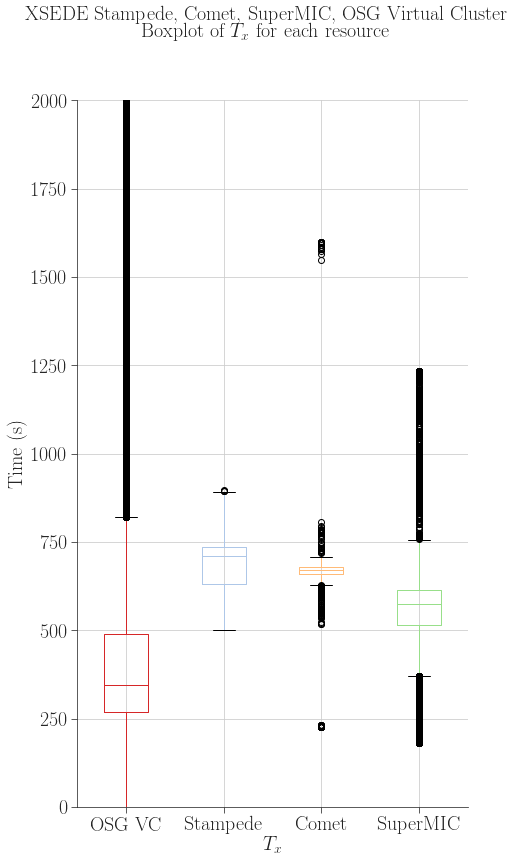

In [64]:
fig = plt.figure(figsize=(7,13))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title_head = 'XSEDE Stampede, Comet, SuperMIC, OSG Virtual Cluster'
title_desc = 'Boxplot of $T_x$ for each resource'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

index   = ['OSG VC','Stampede','Comet','SuperMIC']

medians = [uosg['U_AGENT_EXECUTING'].dropna(),
         ustampede['U_AGENT_EXECUTING'].dropna(),
         ucomet['U_AGENT_EXECUTING'].dropna(),
         usupermic['U_AGENT_EXECUTING'].dropna()]

stds    = [uosg['U_AGENT_EXECUTING'].dropna().std(),
         ustampede['U_AGENT_EXECUTING'].dropna().std(),
         ucomet['U_AGENT_EXECUTING'].dropna().std(),
         usupermic['U_AGENT_EXECUTING'].dropna().std()]

txs     = pd.concat([uosg['U_AGENT_EXECUTING'].dropna(), 
                     ustampede['U_AGENT_EXECUTING'].dropna(),
                     ucomet['U_AGENT_EXECUTING'].dropna(),
                     usupermic['U_AGENT_EXECUTING'].dropna()], 
                    axis=1, 
                    keys=['OSG VC', 
                          'Stampede', 
                          'Comet', 
                          'SuperMIC'])


colors = [tableau20[6],tableau20[1],tableau20[3],tableau20[5]]

# Print sample sizes
print 'OSG sample size: %i' % len(uosg['U_AGENT_EXECUTING'].dropna())
print 'Stampede sample size: %i' % len(ustampede['U_AGENT_EXECUTING'].dropna())
print 'Comet sample size: %i' % len(ucomet['U_AGENT_EXECUTING'].dropna())
print 'SuperMIC sample size: %i' % len(usupermic['U_AGENT_EXECUTING'].dropna())


bp = txs.boxplot(column=['OSG VC','Stampede','Comet','SuperMIC'], ax=ax, return_type='dict')

# Set color boxes
bp['boxes'][0].set_color(colors[0])
bp['boxes'][1].set_color(colors[1])
bp['boxes'][2].set_color(colors[2])
bp['boxes'][3].set_color(colors[3])

# Set color medians
bp['medians'][0].set_color(colors[0])
bp['medians'][1].set_color(colors[1])
bp['medians'][2].set_color(colors[2])
bp['medians'][3].set_color(colors[3])

# Set color whiskers
bp['whiskers'][0].set_color(colors[0])
bp['whiskers'][1].set_color(colors[0])
bp['whiskers'][2].set_color(colors[1])
bp['whiskers'][3].set_color(colors[1])
bp['whiskers'][4].set_color(colors[2])
bp['whiskers'][5].set_color(colors[2])
bp['whiskers'][6].set_color(colors[3])
bp['whiskers'][7].set_color(colors[3])

ax.set_ylim(0, 2000)
ax.set_ylabel('Time (s)')
ax.set_xlabel('$T_x$')

#plt.savefig('figures/xsede_tx_frequency.pdf', dpi=600, bbox_inches='tight')